In [1]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.callback.tracker import *
from fastai2.callback.all     import *
# import albumentations
# from albumentations.core.transforms_interface import DualTransform

import os
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv('../../input/folded_data/train_with_fold.csv')

In [20]:
df[['grapheme_root', 'consonant_diacritic']]

,grapheme_root,consonant_diacritic
0,15,5
1,159,0
2,22,5
3,53,2
4,71,5
...,...,...
200835,22,2
200836,65,0
200837,2,4
200838,152,0


In [3]:
sz = 128
bs = 128
nfolds = 5 #keep the same split as the initial dataset
fold = 0
SEED = 1337
arch = xresnet50
cnt = Path('../input')
md = cnt/'bengaliai-cv19'
LABELS = cnt/'bengali-fold-df/train_with_fold.csv'
TRAIN = cnt/'grapheme-imgs-128x128'

In [4]:
df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.head()

[168, 11, 7, 1295, 200840]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,3
1,Train_1,159,0,0,হ,1,2
2,Train_2,22,3,5,খ্রী,2,4
3,Train_3,53,2,2,র্টি,3,2
4,Train_4,71,9,5,থ্রো,4,1


In [5]:
get_image = lambda x: TRAIN/f'{x[0]}.png'
def get_labels(x): return tensor(x[1:4].astype('uint8'))

In [6]:
gv = L(o for o in df['grapheme_root'].unique() if o==o).sorted()
vv = L(o for o in df['vowel_diacritic'].unique() if o==o).sorted()
cv = L(o for o in df['consonant_diacritic'].unique() if o==o).sorted()

In [7]:
cs = L(len(gv),len(vv),len(cv))
vocab = L(gv,vv,cv); vocab

(#3) [(#168) [0,1,2,3,4,5,6,7,8,9...],(#11) [0,1,2,3,4,5,6,7,8,9...],(#7) [0,1,2,3,4,5,6]]

In [8]:
class MEMCategorize(Transform):
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab): self.vocab,self.c = vocab,L(len(cls) for cls in vocab)
    def encodes(self, o): return TensorCategory(tensor(o).float())
    def decodes(self, o): return MultiCategory (tensor(o))

In [9]:
split_idx = IndexSplitter(df.loc[df.fold==fold].index)(df)

In [10]:
type_tfms = [[get_image, PILImageBW.create, ToTensor], [get_labels, MEMCategorize(vocab=vocab)]]
item_tfms = [ToTensor]
batch_tfms = [IntToFloatTensor, Brightness(max_lighting=0.3, p=0.5), Contrast(), 
             Rotate(max_deg=10, p=0.5), Warp(magnitude=0.1), RandomErasing(), AffineCoordTfm(size=sz)]
# batch_tfms = aug_transforms(do_flip=False, size=sz)

In [11]:
dsrc = Datasets(df.values, type_tfms, splits=split_idx)
tdl = TfmdDL(dsrc, bs=bs, after_item=item_tfms, after_batch=batch_tfms, device=default_device())

In [12]:
xb,_ = tdl.one_batch()
mega_batch_stats = xb.mean(), xb.std()
mega_batch_stats

(TensorImageBW(0.0716, device='cuda:0'),
 TensorImageBW(0.2028, device='cuda:0'))

In [13]:
batch_tfms += [Normalize.from_stats(*mega_batch_stats)]

In [14]:
tdl_train = TfmdDL(dsrc.train, bs=bs, after_item=item_tfms, after_batch=batch_tfms, device=default_device())
tdl_valid = TfmdDL(dsrc.valid, bs=bs, after_item=item_tfms, after_batch=batch_tfms, device=default_device())

In [15]:
dbch = DataLoaders(tdl_train, tdl_valid, device=default_device())

In [16]:
dbch.one_batch()[0].std(), dbch.one_batch()[0].mean()

(TensorImageBW(0.8932, device='cuda:0'),
 TensorImageBW(0.0002, device='cuda:0'))

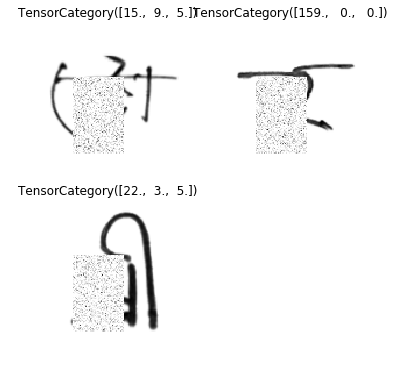

In [17]:
dbch.show_batch(max_n=3)

In [18]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [19]:
class Head(Module):
    def __init__(self, nc, n, ps=0.5):
        self.fc = nn.Sequential(*[AdaptiveConcatPool2d(), Mish(), Flatten(),
             LinBnDrop(nc*2, 512, True, ps, Mish()),
             LinBnDrop(512, n, True, ps)])
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)

# class CascadeModel(Module):
#     def __init__(self, arch=arch, n=dbch.c, pre=True):
#         m = arch(pre)
#         conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         w = (m.features.conv0.weight.sum(1)).unsqueeze(1)
#         conv.weight = nn.Parameter(w)
#         self.layer0 = nn.Sequential(conv, m.features.norm0, nn.ReLU(inplace=True))
#         self.layer1 = nn.Sequential(
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
#             m.features.denseblock1)
#         self.layer2 = nn.Sequential(m.features.transition1,m.features.denseblock2)
#         self.layer3 = nn.Sequential(m.features.transition2,m.features.denseblock3)
#         self.layer4 = nn.Sequential(m.features.transition3,m.features.denseblock4,
#                                     m.features.norm5)
#         nc = self.layer4[-1].weight.shape[0]

#         self.heads = nn.ModuleList([Head(nc, c) for c in n])
        
#     def forward(self, x):        
#         x = self.layer0(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         return [f(x) for f in self.heads]

In [20]:
class CascadeModel(Module):
    def __init__(self, arch=arch, n=dbch.c, pre=True):
        m = arch(pre)
        m = nn.Sequential(*children_and_parameters(m)[:-4])
        conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        w = (m[0][0].weight.sum(1)).unsqueeze(1)
        conv.weight = nn.Parameter(w)
        m[0][0] = conv
        nc = m(torch.zeros(2, 1, sz, sz)).detach().shape[1]
        self.body = m
        self.heads = nn.ModuleList([Head(nc, c) for c in n])
        
    def forward(self, x):    
        x = self.body(x)
        return [f(x) for f in self.heads]

In [21]:
class Loss_combine(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 0.7*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.1*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          0.2*F.cross_entropy(x3,y[:,2],reduction=reduction)

In [22]:
class RecallPartial(Metric):
    # based on AccumMetric
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, a=0, **kwargs):
        self.func = partial(recall_score, average='macro', zero_division=0)
        self.a = a

    def reset(self): self.targs,self.preds = tensor([]), tensor([])

    def accumulate(self, learn):
        fp,sp,tp = learn.pred
        preds,targs = torch.stack((fp.argmax(-1),sp.argmax(-1),tp.argmax(-1)), dim=-1).float(),learn.y
        preds,targs = to_detach(preds),to_detach(targs)
        self.preds = torch.cat((self.preds, preds))
        self.targs = torch.cat((self.targs, targs))

    @property
    def value(self):
        if len(self.preds) == 0: return
        return self.func(self.targs[:, self.a], self.preds[:, self.a])

    @property
    def name(self): return df.columns[self.a+1]
    
class RecallCombine(Metric):
    def accumulate(self, learn):
        scores = [learn.metrics[i].value for i in range(3)]
        self.combine = np.average(scores, weights=[7,1,2])

    @property
    def value(self):
        return self.combine

In [23]:
from torch.distributions.beta import Beta
def NoLoss(*o): pass
class CustomMixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
        
    def begin_fit(self):self.loss_func0 = self.learn.loss_func
        
    def begin_batch(self):
        self.learn.loss_func = NoLoss
        lam = self.distrib.sample((self.y[:, 0].size(0),)).squeeze().to(self.x[0].device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y[:, 0].size(0)).to(self.x.device)
        xb1 = tuple(L(self.xb).itemgot(shuffle))
        yb1 = tuple([self.yb[i][shuffle] for i in range(len(self.yb))])
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        self.learn.yb = yb1,self.yb
        
    def after_loss(self):
        loss0 = self.loss_func0(self.learn.pred, *self.learn.yb[0], reduction='none')
        loss1 = self.loss_func0(self.learn.pred, *self.learn.yb[1], reduction='none')
        self.learn.loss = torch.lerp(loss0, loss1, self.lam).mean()
        self.learn.loss_func = self.loss_func0

In [24]:
model = CascadeModel()

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/checkpoints/xrn50_940.pth
100%|██████████| 244M/244M [00:06<00:00, 38.3MB/s]


In [25]:
learn = Learner(dbch, model, loss_func=Loss_combine(), cbs=[CustomMixUp(0.4)],
               metrics=[RecallPartial(a=i) for i in range(len(dbch.c))] + [RecallCombine()],
               splitter=lambda m: [list(m.body.parameters()), list(m.heads.parameters())])
                

In [26]:
learn.to_fp16()

In [27]:
# learn._split([model.heads[0]])

In [28]:
# learn.recorder.lr_find()

In [29]:
learn.fit_one_cycle(40, lr_max=slice(1e-3, 1e-2), 
                    cbs=[ReduceLROnPlateau(patience=3), SaveModelCallback(fname=f'xresnet50_{fold}fold')])

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,2.999986,2.136846,0.219806,0.563923,0.439226,0.298102,10:05
1,2.275701,1.324592,0.413177,0.747027,0.789729,0.521872,08:35
2,2.044111,0.819957,0.665994,0.867736,0.826164,0.718202,08:31
3,1.813041,0.610260,0.712102,0.894196,0.896538,0.767199,08:31
4,1.678119,0.466592,0.780876,0.919593,0.926661,0.823904,08:29
5,1.536136,0.447444,0.813068,0.928721,0.914679,0.844956,08:29
6,1.539540,0.412593,0.820560,0.914265,0.929991,0.851817,08:30
7,1.462486,0.287229,0.883364,0.945848,0.943472,0.901634,08:29
8,1.495536,0.301351,0.875700,0.950979,0.943002,0.896688,08:30
9,1.289147,0.269118,0.906729,0.967442,0.923857,0.916226,08:31


In [30]:
learn.fit_one_cycle(10, lr_max=slice(1e-4, 3e-3),
                    cbs=[ReduceLROnPlateau(patience=2), SaveModelCallback(fname=f'cont_xresnet50_{fold}fold')])

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,0.829904,0.105278,0.958791,0.985825,0.978542,0.965444,08:33
1,0.857490,0.107948,0.958691,0.985876,0.979278,0.965527,08:32
2,0.820147,0.107874,0.956268,0.986330,0.980769,0.964174,08:32
3,0.836257,0.107031,0.958265,0.986441,0.979565,0.965343,08:32
4,0.840224,0.106948,0.958848,0.985116,0.979080,0.965521,08:33
5,0.842000,0.105535,0.960154,0.986822,0.980615,0.966913,08:33
6,0.805541,0.104467,0.960147,0.986139,0.977853,0.966287,08:38
7,0.745785,0.103792,0.959889,0.986286,0.979112,0.966373,08:42


Epoch 2: reducing lr to 0.0002967325657497723
Epoch 4: reducing lr to 0.00022504407622898453
